# Mean Shift

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
data = pd.read_csv('data_csv/data1.csv')

In [ ]:
data.head()

In [ ]:
def display_cluster_cir(X,km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X['theta'],X['r'],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X['theta'][km.labels_==i],X['r'][km.labels_==i],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [ ]:
display_cluster_cir(data)

# Mean shift

In [ ]:
class Distances(object):
    
    
    @staticmethod
    def norm_p(centroid, w, data, norm=2, isNorm=False):                  
        distance = data.copy()
        encircling_points = 0
        for dim in range(point.shape[0], 0, -1):
            dim -= 1
            distance[:, dim] = np.power(data[:, dim]-centroid[dim], norm)
        
        distance = distance.sum(axis=1)
        distance = np.power(distance, 1/norm)
            
        if not isNorm:
            encircling_points = data[distance <= w]
        
        return encircling_points, centroid, distance
        
    
    @staticmethod
    def draw_circle_area(redius, center, inner_points, all_data, isDataVisualization=False, title='Fig'):
        plt.ion()
        circle = plt.Circle((center[0], center[1]), redius, color='b', fill=False)
        fig, ax = plt.subplots(1,1)
        # ax.cla()
        
        # ax.set_xlim((-100, 100))
        # ax.set_ylim((-100, 100))
        ax.set_title(title)
        # center
        ax.plot(center[0], center[1], 'o', color='r')

        if not isDataVisualization:
            # data points
            ax.plot(inner_points[:, 0], inner_points[:, 1], 'x', color='g')
        
            # other points
            other_points=all_data.copy()
            for i in inner_points:
                other_points = other_points[np.all(other_points!=i, axis=1)]

            ax.plot(other_points[:, 0], other_points[:, 1], 'o', color='y')
        else:
            ax.plot(all_data[:, 0], all_data[:, 1], 'o', color='y')

        ax.add_patch(circle)
        
        fig.canvas.draw()

    @staticmethod
    def draw_rect_area(xy, wh, inner_points, all_data, isDataVisualization=False):
        diff = xy[0] - min(point[:, 0])
        center = (xy[0]-(wh/2), min(point[:, 1]) - 1)
        rect = patches.Rectangle(center, wh, wh, linewidth=1, edgecolor='b', facecolor='none')
        ax = plt.gca()
        ax.cla()
        # ax.set_xlim((-100, 100))
        # ax.set_ylim((-100, 100))
        
        # center
        ax.plot(xy[0], xy[1], 'o', color='r')

        if not isDataVisualization:
            # data points
            ax.plot(inner_points[:, 0], inner_points[:, 1], 'x', color='g')
        
            # other points
            other_points=all_data.copy()
            for i in inner_points:
                other_points = other_points[np.all(other_points!=i, axis=1)]

            ax.plot(other_points[:, 0], other_points[:, 1], 'o', color='y')
        else:
            ax.plot(all_data[:, 0], all_data[:, 1], 'o', color='y')


        
        ax.add_patch(rect)
        
        

In [ ]:
class Mean_Shift(object):
    def __init__(self, bandwidth, data, dist='l2', kernel='G'):
        self.dist = dist
        self.bandwidth = bandwidth
        self.data = data
        self.kernel = kernel
        self.clusters = {}
    
    def identify_norm(self):
        return int(self.dist.split('l')[1])

    def fit(self):

        for point in self.data:
            _, cluster_center = self._itr(point)
            cluster_center = f"{(cluster_center[0], cluster_center[1])}"

            if cluster_center in self.clusters:
                self.clusters[cluster_center].append(point)
            else:
                self.clusters[cluster_center] = [point]

    def show(self):
        ax = plt.gca()
        ax.cla()
        color = 'brgcmyk'
        numbers = [0, 1, 2, 3, 4, 5]
        choice = 0
        print(f"number of clusters: {len(self.clusters.keys())}")
        for key in self.clusters.keys():

            p = np.array(self.clusters[key])
            ax.plot(p[:, 0], p[:, 1], 'o', color=color[choice])
            
            if choice != 5:
                choice +=1
        
    def _gausian_kernel(self, points, centeroid):
        cent_X = centeroid[0]
        cent_Y = centeroid[1]
        _, _, norm2 = Distances.norm_p(centroid=np.array((cent_X, cent_Y)), data=points, w=self.bandwidth, norm=2, isNorm=True)
        norm2 /= self.bandwidth
        norm2 = np.exp(-2 * np.power(norm2, 2))        
        result = np.multiply(np.power(2 * np.pi, -self.bandwidth/2), norm2)
        return result
    
    def _itr(self, point):
        x_hat = np.array((point[0], point[1]))
        
        while True:
            encircling_points, center, _ = Distances.norm_p(centroid=x_hat, w=self.bandwidth, data=self.data, norm=self.identify_norm())
            Distances.draw_circle_area(self.bandwidth, x_hat, encircling_points, self.data, isDataVisualization=True, title=f"point: {point}")

            if self.kernel == 'G':
                if len(encircling_points) > 0:
                    fx = self._gausian_kernel(points=encircling_points, centeroid=x_hat)
                    fx_d = np.reshape(fx, (fx.shape[0], 1))                                     
                    fx_d = np.insert(fx_d, 1, fx,axis=1)
                    fx = fx_d 
                    
                    ss = encircling_points - x_hat
                    numerator = np.multiply(ss, fx).sum(axis=0)
                    denumerator = fx.sum()
                    updated_mean = numerator / denumerator
                    x_hat = updated_mean + x_hat
                   

                else:
                    center = x_hat
            
            if (x_hat==np.array([center])).all():
                # print(f"Convergence: point: {point}, center: {center}")
                return point, center

In [ ]:
ms1 = Mean_Shift(bandwidth=2, data=data.to_numpy())
ms1.fit()
ms1.show()

/var/folders/73/m692bsjd2y7dnrhkgyg222bc0000gn/T/ipykernel_8566/2273580574.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


In [1194]:
data2 = pd.read_csv('data_csv/data2.csv')
data2.head()

,theta,r
0,5.748908,6.841916
1,0.213544,5.299996
2,6.022506,5.272700
3,0.005947,4.842755
4,6.184211,3.885591


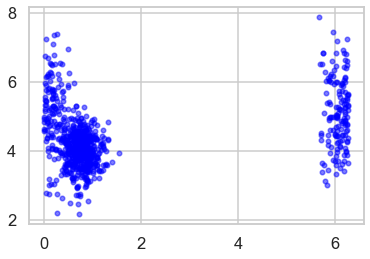

In [1195]:
display_cluster_cir(data2)

number of clusters: 4


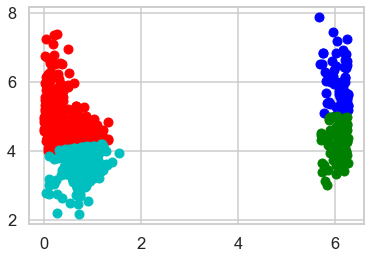

In [1196]:
ms2 = Mean_Shift(bandwidth=2, data=data2.to_numpy())
ms2.fit()
ms2.show()

In [1197]:
data3 = pd.read_csv('data_csv/data3.csv')
data3.head()

,theta,r
0,5.677650,4.678962
1,5.809434,5.636904
2,0.260347,4.368464
3,0.220961,5.736584
4,0.007053,4.564608


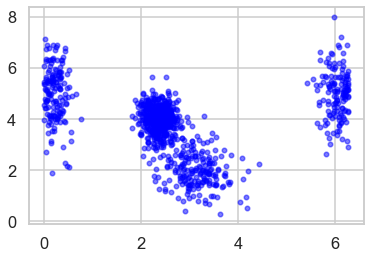

In [1198]:
display_cluster_cir(data3)

number of clusters: 4


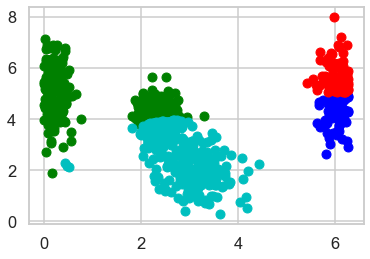

In [1199]:
ms3 = Mean_Shift(bandwidth=2, data=data3.to_numpy())
ms3.fit()
ms3.show()

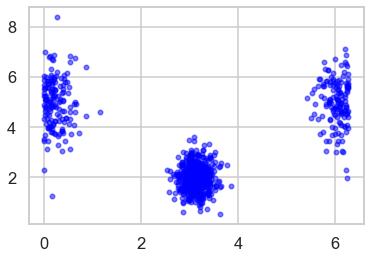

In [1200]:
data4 = pd.read_csv('data_csv/data4.csv')
display_cluster_cir(data4)

number of clusters: 6


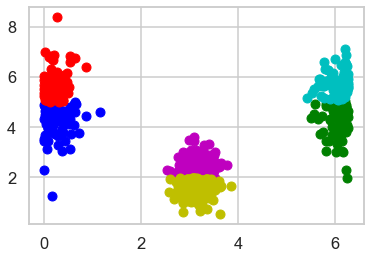

In [1201]:
ms4 = Mean_Shift(bandwidth=2, data=data4.to_numpy())
ms4.fit()
ms4.show()

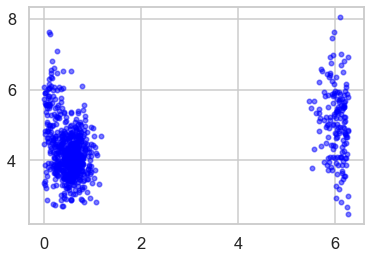

In [1202]:
data5 = pd.read_csv('data_csv/data5.csv')
display_cluster_cir(data5)

In [1203]:
ms5 = Mean_Shift(bandwidth=2, data=data5.to_numpy())
ms5.fit()
ms5.show()

KeyboardInterrupt: 

In [ ]:
data6 = pd.read_csv('data_csv/data6.csv')
display_cluster_cir(data6)

In [ ]:
ms6 = Mean_Shift(bandwidth=2, data=data6.to_numpy())
ms6.fit()
ms6.show()

In [ ]:
data7 = pd.read_csv('data_csv/data7.csv')
display_cluster_cir(data7)

In [ ]:
ms7 = Mean_Shift(bandwidth=2, data=data7.to_numpy())
ms7.fit()
ms7.show()